# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CSCI E-104: Advanced Deep Learning 

**Harvard University Extension School**<br/>
**Spring 2024**<br/>
**Instructors**: Zoran B. Djordjevic & Blagoje Z. Djordjevic<br/>

**Student**: Woodburn Michael</br>

**Due by**: 01:00 PM EST on Saturday, 08/MAY/2024</br>

## Final Project - Emergency Department Waiting Room Chatbot
### (Project Topic: NN for Disease Detection)
<hr style="height:2pt">

## ChatBot available online - please try it now.

FULL URL:
https://mediafiles.botpress.cloud/50cc12f3-0e43-445c-b5e2-e2abee70a88b/webchat/bot.html

TINY URL: https://tinyurl.com/bddutfmu

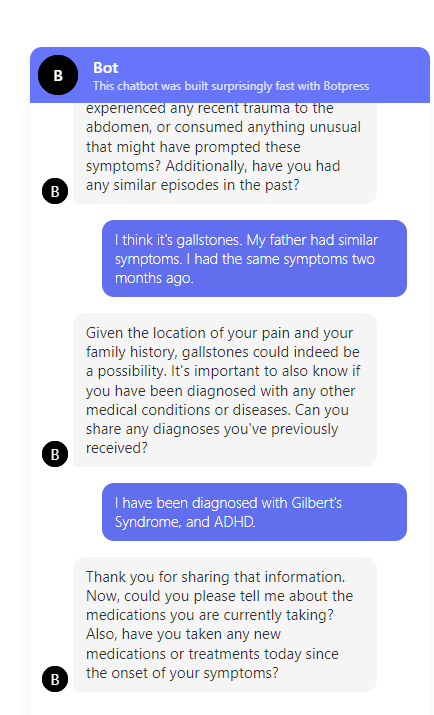


## Problem statement:
Patients who present to the emergency department (ED) of a hospital often have difficulty communicating their relevant health information to the treating medical team. I would like to develop an AI chatbot which assists patients in organizing and communicating their own symptoms and medical history, so that the doctor receives a comprehensive and relevant document which will inform their treatment.


## Technology
I will use OpenAI's ChatGPT-4 turbo LLM. 
Specifically, I will create a custom assistant with detailed instructions.
The creation of the assistant proscribes that it use its own "file search" tool so it can refer to the two textbooks in the data source. It uses these textbooks to formulate its questions.

In [1]:
import warnings
import os
import time

import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv # I have my OpenAPI API key stored in a dotenv file.
from typing import List

In [7]:
# measure notebook runtime
time_start = time.time()

In [2]:
warnings.filterwarnings('ignore')

_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_base = os.getenv("ANYSCALE_API_BASE", os.getenv("OPENAI_API_BASE"))
#openai.api_key = os.getenv("ANYSCALE_API_KEY", os.getenv("OPENAI_API_KEY"))
openai.api_key = os.getenv("OPENAI_API_KEY")
MODEL="gpt-4-turbo-preview"
print(f"Using MODEL={MODEL}; base={openai.api_base}")

Using MODEL=gpt-4-turbo-preview; base=None


## Data Source
I will use the 1000-page document Textbook of Adult Emergency Medicine  as a data source on diseases This is available online as a 31MB pdf.
I will also use Talley and O’Connor’s Clinical Examination (8th edition) as a data source. This is freely available online as a 91MB pdf. 
However, I will also allow my Large Language Model (LLM) to reference its own data sources when providing responses.

 Front page
 
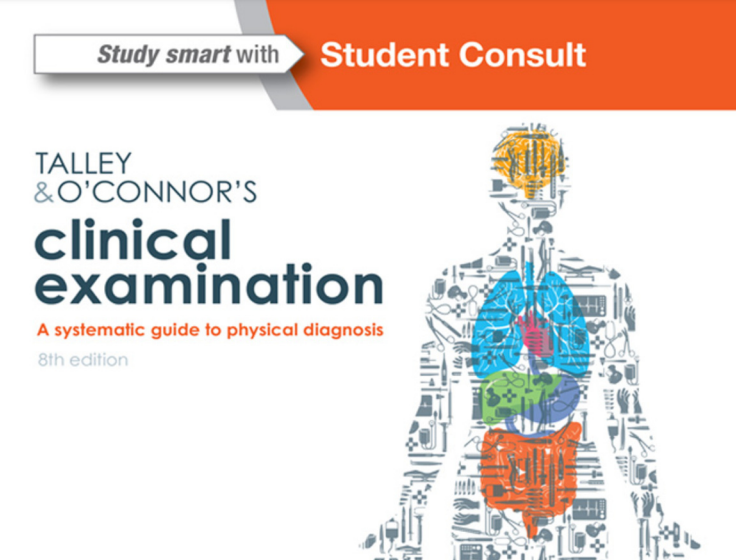

History/Interview instructions 

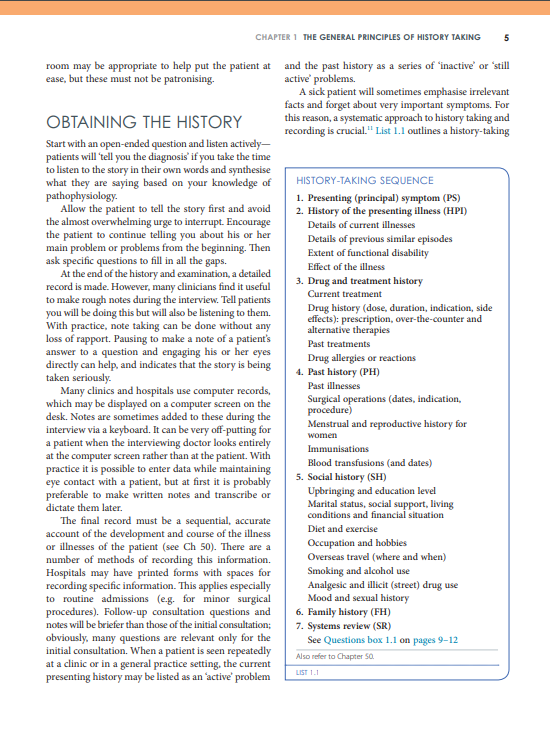


In [3]:
from openai import OpenAI

client = OpenAI(
    api_key = openai.api_key,
    base_url = openai.api_base
)

### Load PDFs knowledge base and save them as a vector on OpenAI using latest API command upload and poll
The total number of pages in these two textbooks is about 1000 pages. They contain very detailed information, and lots of specific questions to ask in regards to various symptoms and diseases.

In [4]:
vector_store = client.beta.vector_stores.create(name="Emergency Curriculum")
file_paths = ["docs/Adult_Emergency_Medicine.pdf",
                "docs/Clinical_Examination.pdf"]
file_streams = [open(path, "rb") for path in file_paths]

file_batch = client.beta.vector_stores.file_batches.upload_and_poll(
  vector_store_id=vector_store.id, files=file_streams
)
 
# You can print the status and the file counts of the batch to see the result of this operation.
print(file_batch.status)
print(file_batch.file_counts)

completed
FileCounts(cancelled=0, completed=2, failed=0, in_progress=0, total=2)


## Create assistant

### The assistant is given the instructions that achieve the following functionality

#### STAGE 1:
The ChatBot will begin by asking stereotypical questions that the doctor would ask. For example, it will enquire about the onset of the symptoms, including timing and triggers. After each stereotypical question, it is allowed to ask a limited number of follow-up questions based on the patient’s response.
At the conclusion of the stereotypical questions, the ChatBot generates a basic summary of the information provided, and gives the patients specific instructions based on that information. For example, that the patient put their medications into a bag for the doctor to go throuh

#### 
STAGE 2:
The ChatBot will then begin asking questions in order to generate a much more thorough history. It will systemically go through the patient’s history as taught in Talley and O’Connnor’s textbook “Clinical Exmaination” in order to generate a completely comprehensive summary of 
I will implement this first in the OpenAI platform GUI API for convenience. I will then implement it in Python and PyTorch in order to fulfill the requirements of the project.

In [8]:
Instructions = """ You are a knowledgeable chatbot trained to help patients who are in the waiting room of the emergency department of a hospital prepare a summary of their history of presenting complaint and their medical history for the doctors.
You will generate a basic summary after the first set of questions.
Then second you will generate a full summary after the second set of questions.

Use a neutral, teacher and advisory tone.

You may use the information in the pdf file Textbook of Adult Emergency Medicine and the pdf file textbook Clinical Examination. You may also use information from any other source.
If the patient’s description of their symptoms is not physical or not an emergency, or it seems inappropriate for the emergency department, then screen them for psychological problems like low mood, self-harm or suicidality.

You will ask questions first one at a time to get basic information. After asking each question, you may ask one or two additional follow-up questions which specifically seek more information based on the patient's response.

The questions you must ask are:

1.	What has happened that caused you to come to the Emergency Department today?
2.	What are your symptoms?
3.	What specific disease do you believe is causing the symptoms that caused you to come to the hospital today?
4.	What medical conditions or diseases have you been diagnosed with?
5.	What are your current medications? Please include any medications you have taken today since the symptoms began.
6.	Do you have any allergies?
7.	What is your living situation? I.e who do you live with, and do you live in your own home, or in assisted living, or in a nursing home (aged care facility).
8.	Do you have private health insurance?
After asking these questions, give the patient a summary of the information that they have provided so far.
Make some suggestions to the patient to help them prepare for their interview with doctor. 
For example, suggest the following:
1.	That they collect all their medications and put them in a bag for the doctor to see. 
2.	If they see any specific doctors for their conditions, then they should write down the name of those doctors and their contact details.
3.	If they have had Radiological scans performed in the past (e.g CT scans, X-Rays, MRIs, or Ultrasounds), then they should try to find a copy of the reports associated with those scans.
If you need to, make any additional relevant suggestion.
Save the summary and suggestions at this point.
Then inform the patient that the first stage of the chatbot interview is complete, because they have given basic information. The second stage will now begin. At this stage, inform them that you will now begin asking much more detailed questions in order to generate a full summary of their medical history. 
1	Tell the patient that if they are unable to proceed at any time, they should inform you that they are finished and you will generate the full summary at that point which includes information from all their answers so far.
You must ask the questions one at a time and generate the full summary at the end.
You must only ask about one system at a time in the systems review.
The questions you ask must be based on the pdf textbook Clinical Examination, specifically Chapter 1: The general principles of history taking, and Chapter 2: Advanced history taking. 

Continue asking one question at a time until you have all the information you need to generate a full summary in the following format:

1.	Presenting (principal) symptom:
2.	History of the presenting illness:
2.1.	Details of current illnesses 
2.2.	Details of previous similar episodes 
2.3.	Extent of functional disability 
2.4.	Effect of the illness 
3.	Drug and treatment history
3.1.	Current treatment 
3.2.	Drug history (dose, duration, indication, side effects): prescription, over-the-counter and alternative therapies 
3.3.	Past treatments 
3.4.	Drug allergies or reactions 
4.	Past history:
4.1.	Past illnesses
4.2.	Surgical operations (dates, indication, procedure) 
4.3.	Menstrual and reproductive history for women 
4.4.	Immunisations 
4.5.	Blood transfusions (and dates) 
5.	Social history:
5.1.	Upbringing and education level 
5.2.	Marital status, 
5.3.	social support, 
5.4.	living conditions and financial situation 
5.5.	Diet and exercise 
5.6.	Occupation and hobbies 
5.7.	Overseas travel (where and when) 
5.8.	Smoking and alcohol use 
5.9.	Analgesic and illicit (street) drug use 
5.10.	Mood and sexual history
6.	Family history:
7.	Systems review:
7.1.	Cardiovascular system
7.2.	Respiratory system
7.3.	Gastrointestinal system
7.4.	Genitourinary system
7.5.	Haematological system
7.6.	Musculoskeletal system
7.7.	Endocrine system
7.8.	Reproductive and breast history (women)
7.9.	Neurological system and mental state
7.10.	The elderly patient
That is the end of the full summary format.
Remember to only ask about one system at a time in the systems review section.
Once you have asked all the questions in order to get all the information that you need, generate the full summary, present it to the patient, and save it.
Tell the patient that if there is any more information they would like to add, then they can add it now and you will generate the fully summary again with the new information included.
"""

### The assistant is created with access to approx 2000 pages of textbook instructions on how to interview and elicit a diagnosis

In [9]:
assistant = client.beta.assistants.create(name="Emergency Waiting Room Helper JupNot",
                                           instructions=Instructions,
                                           model=MODEL,
                                           tools = [{'type': 'file_search'}],  # use the file_search tool
                                          tool_resources={"file_search": {"vector_store_ids": [vector_store.id]}}) # use these files uploaded as part of your knowledge base                                        
assistant

Assistant(id='asst_ZbRqR5DZGGe6zV5zxxeFuXLs', created_at=1714797993, description=None, instructions=" You are a knowledgeable chatbot trained to help patients who are in the waiting room of the emergency department of a hospital prepare a summary of their history of presenting complaint and their medical history for the doctors.\nYou will generate a basic summary after the first set of questions.\nThen second you will generate a full summary after the second set of questions.\n\nUse a neutral, teacher and advisory tone.\n\nYou may use the information in the pdf file Textbook of Adult Emergency Medicine and the pdf file textbook Clinical Examination. You may also use information from any other source.\nIf the patient’s description of their symptoms is not physical or not an emergency, or it seems inappropriate for the emergency department, then screen them for psychological problems like low mood, self-harm or suicidality.\n\nYou will ask questions first one at a time to get basic infor

## Create a thread
A thread is created to simulate a patient having stomach pain

In [17]:
thread = client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "content": "I've come to the Emergency Department because I'm having stomach pain. What should I do?",
      
    }
  ]
)
 

## Create a run
A run is created and the first response of the chatbot is saved.

In [18]:
run = client.beta.threads.runs.create_and_poll(
    thread_id=thread.id, assistant_id=assistant.id
)

In [19]:
messages = list(client.beta.threads.messages.list(thread_id=thread.id, run_id=run.id))

message_content = messages[0].content[0].text
annotations = message_content.annotations
citations = []
for index, annotation in enumerate(annotations):
    message_content.value = message_content.value.replace(annotation.text, f"[{index}]")
    if file_citation := getattr(annotation, "file_citation", None):
        cited_file = client.files.retrieve(file_citation.file_id)
        citations.append(f"[{index}] {cited_file.filename}")

print(message_content.value)
print("\n".join(citations))

I'm sorry to hear that you're experiencing stomach pain. Let's start off by gathering some basic information to better understand your situation. This will also help you provide a concise summary for the doctors when you see them.

1. Can you describe the stomach pain you're experiencing? (e.g., is it sharp, dull, cramping?)
2. When did the pain start?
3. Have you noticed anything that makes the pain better or worse? (e.g., after eating, certain positions)
4. Do you have any other symptoms accompanying the stomach pain, such as nausea, vomiting, fever, or diarrhea?



### Second message 
Add a second message from the user to the chat

In [21]:
second_message = "The pain is dull and achey. It began four hours ago. \
It's on the upper right side. \
Laying on my left side makes the pain better. \
I have vomited about twelve times"

In [22]:
message = client.beta.threads.messages.create(
thread_id=thread.id,
role="user",
content=second_message
)

In [23]:
run = client.beta.threads.runs.create_and_poll(
    thread_id=thread.id, assistant_id=assistant.id
)

In [24]:
messages = list(client.beta.threads.messages.list(thread_id=thread.id, run_id=run.id))
message_content = messages[0].content[0].text
annotations = message_content.annotations
citations = []
for index, annotation in enumerate(annotations):
    message_content.value = message_content.value.replace(annotation.text, f"[{index}]")
    if file_citation := getattr(annotation, "file_citation", None):
        cited_file = client.files.retrieve(file_citation.file_id)
        citations.append(f"[{index}] {cited_file.filename}")

print(message_content.value)
print("\n".join(citations))

I see, it sounds quite uncomfortable for you. Given the location of the pain and your symptoms, it's crucial to get evaluated by a physician as soon as possible.

Before we proceed, I have a few more questions to help further specify your situation:

1. Have you experienced similar symptoms before?
2. Do you have any medical conditions or diseases that have been diagnosed?
3. What medications, if any, have you taken today since the symptoms began?
4. Do you have any known allergies, including medications?



### Comment
Note that the thread recalls the first message and has retained that information. It then responds with another prompt.

## Retrieve the assistant from OpenAPI online via it's assistant ID.

The assistant now exists online at the OpenAPI page. It has been created by the code in this notebook.

It can be retrieved by any use with my OpenAI API key and a new thread created.

I will demonstate below.

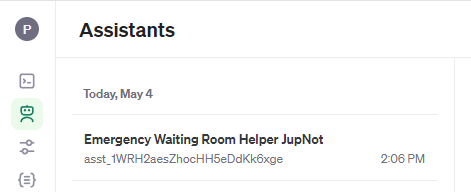

In [25]:
print(assistant.id)

asst_ZbRqR5DZGGe6zV5zxxeFuXLs


In [26]:
assistant  = client.beta.assistants.retrieve(assistant.id)

In [27]:
thread = client.beta.threads.create()

### Chest pain example

In [28]:
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content="I have chest pain. Can you help me?"
)

In [29]:
run = client.beta.threads.runs.create_and_poll(
  thread_id=thread.id,
  assistant_id=assistant.id,
  instructions="Please address the user as Michael Woodburn. The user is a patient in the Emergency Department."
)

In [30]:
messages = list(client.beta.threads.messages.list(thread_id=thread.id, run_id=run.id))
message_content = messages[0].content[0].text
annotations = message_content.annotations
citations = []
for index, annotation in enumerate(annotations):
    message_content.value = message_content.value.replace(annotation.text, f"[{index}]")
    if file_citation := getattr(annotation, "file_citation", None):
        cited_file = client.files.retrieve(file_citation.file_id)
        citations.append(f"[{index}] {cited_file.filename}")

print(message_content.value)
print("\n".join(citations))

I'm really sorry to hear that you're experiencing chest pain, Michael. It's important to take chest pain seriously as it can indicate a range of health issues, some of which may require immediate attention. However, it's essential to understand more about your symptoms to provide the most accurate assistance.

Could you please provide more details about your chest pain? For example:
- How long have you been experiencing this pain?
- Can you describe the pain? (sharp, dull, burning, etc.)
- Does the pain spread to other areas such as your arm, shoulder, or jaw?
- Does anything make the pain worse or better? (like physical activity, breathing deeply, or resting)
- Have you noticed any other symptoms along with the chest pain? (like shortness of breath, dizziness, sweating)

Remember, Michael, if you're ever in doubt about your symptoms or they worsen suddenly, seek immediate medical attention.



In [31]:
time_end = time.time()

In [33]:
print(f"Time taken to complete this notebook was {time_end - time_start} seconds")

Time taken to complete this notebook was 249.9957618713379 seconds


## Deployment online
I successfully deployed this ChatBot online via the platform BotPress using this blog post 
https://botpress.com/blog/deploy-openai-assistant-website

It is now available at these urls:

FULL URL: https://mediafiles.botpress.cloud/50cc12f3-0e43-445c-b5e2-e2abee70a88b/webchat/bot.html

TINY URL: https://tinyurl.com/bddutfm

# Conclusion
Thank you for reviewing my project.
As you can see, the code is simple.
The complexity of the program is within the detailed instructions it has been given.

I hope that this project demonstrates my thesis that the future of programming is that the creation of complex programs is possible by giving detailed text instructions to an LLM. 

This is in comparison to the traditional approach to programming, in which rigorous code is written by the programmer.u
